# Project: Activity Recognition
- 제출기한: 2022년 1월 28일 금요일 자정
- 제출방법: 이메일 (여러 번 제출할 경우 마지막으로 제출한 파일을 사용)
  - 메일제목: `홍길동 ML project`
  - 제출할 파일: `Project.ipynb`
  - 메일주소: `ta_ml@hcs.snu.ac.kr`

In [12]:
import pickle
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets, neighbors
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
import sklearn.linear_model as skl_lm
from sklearn.metrics import confusion_matrix, classification_report, precision_score, roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler

from statsmodels.discrete.discrete_model import Logit
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings

%matplotlib inline
plt.style.use('seaborn-white')

warnings.filterwarnings('ignore')

## 1. Project Overview
<img src='images/example.png' width='500px' />

* 위 그림과 같이 손목에 달려있는 가속도계의 x, y, z축 가속도 정보를 이용하여 행동을 예측합니다.

## 2. Data Description
### 2.1. Data Overview
* 총 9명으로 이루어진 Activity Recognition Dataset 중 7명을 train data로, 2명의 test data로 사용합니다.
* 2명의 test data는 채점에만 이용되고, 7명의 train data만 주어집니다. (`data/train.pkl`)
* 데이터는 Subject, Motion, Data 열들로 이루어집니다.
  * Subject `int`: 샘플을 수집한 실험자의 id
  * Motion `string`: 행동의 종류
  * Data `(500, 3) shaped numpy array`: x, y, z축의 가속도 측정값 (500 samples = 5초 x 100 samples/초)

### 2.2. Data Load

In [2]:
with open('data/train.pkl', 'rb') as f:
    df = pickle.load(f)
df.head(3)

Subject                                               Data   Motion
0        3  [[-2.115489959716797, 2.9105000495910645, 8.15...  ironing
1        3  [[-3.5734200477600098, 3.9679501056671143, 10....  ironing
2        3  [[-1.7668700218200684, 11.98840045928955, 1.08...  ironing

### 2.3. Data Arangement

In [3]:
# Create MOTION_TO_LABEL_MAP to label motions
MOTIONS = sorted(list(set(df['Motion'])))
LABELS  = [i for i in range(len(MOTIONS))]

MOTION_TO_LABEL_MAP = {motion:label for label, motion in zip(LABELS, MOTIONS)}
LABEL_TO_MOTION_MAP = {label:motion for label, motion in zip(LABELS, MOTIONS)}

print(MOTIONS)

['Nordic walking', 'ascending stairs', 'cycling', 'descending stairs', 'ironing', 'lying', 'rope jumping', 'running', 'sitting', 'standing', 'vacuum cleaning', 'walking']


In [137]:
# Arange data to numpy array
subjects = df['Subject'].values
X        = np.stack(df['Data'])
Y        = df['Motion'].map(MOTION_TO_LABEL_MAP).values


def make_df_to_oneshot(df, columns):
    for i in columns:
        df[i] = 0
    for i in range(df.shape[0]):
        for j in columns:
            if(j in df['Motion'].iloc[i]):
                df.loc[i,j] = 1
    # ============================================
    return None

make_df_to_oneshot(df, MOTIONS)
df

Subject                                               Data  \
0            3  [[-2.115489959716797, 2.9105000495910645, 8.15...   
1            3  [[-3.5734200477600098, 3.9679501056671143, 10....   
2            3  [[-1.7668700218200684, 11.98840045928955, 1.08...   
3            3  [[-4.2224202156066895, 9.517740249633789, 2.67...   
4            3  [[-6.610869884490967, 4.498380184173584, 7.815...   
...        ...                                                ...   
13935        9  [[-1.8887399435043335, 2.340670108795166, 8.27...   
13936        9  [[-5.959249973297119, -7.587969779968262, 1.86...   
13937        9  [[4.046329975128174, 14.204400062561035, -0.56...   
13938        9  [[-14.82509994506836, 37.050201416015625, -8.1...   
13939        9  [[4.965579986572266, 2.059380054473877, -8.590...   

             Motion  Nordic walking  ascending stairs  cycling  \
0           ironing               0                 0        0   
1           ironing               0                 0        0   
2           ironing               0                 0        0   
3           ironing               0                 0        0   
4           ironing               0                 0        0   
...             ...             ...               ...      ...   
13935  rope jumping               0                 0        0   
13936  rope jumping               0                 0        0   
13937  rope jumping               0                 0        0   
13938  rope jumping               0                 0        0   
13939  rope jumping               0                 0        0   

       descending stairs  ironing  lying  rope jumping  running  sitting  \
0                      0        1      0             0        0        0   
1                      0        1      0             0        0        0   
2                      0        1      0             0        0        0   
3                      0        1      0             0        0        0   
4                      0        1      0             0        0        0   
...                  ...      ...    ...           ...      ...      ...   
13935                  0        0      0             1        0        0   
13936                  0        0      0             1        0        0   
13937                  0        0      0             1        0        0   
13938                  0        0      0             1        0        0   
13939                  0        0      0             1        0        0   

       standing  vacuum cleaning  walking  
0             0                0        0  
1             0                0        0  
2             0                0        0  
3             0                0        0  
4             0                0        0  
...         ...              ...      ...  
13935         0                0        0  
13936         0                0        0  
13937         0                0        0  
13938         0                0        0  
13939         0                0        0  

[13940 rows x 15 columns]

In [146]:
gm = df.groupby(['Subject'])
gm.sum()

Nordic walking  ascending stairs  cycling  descending stairs  \
Subject                                                                 
3                     0                95        0                139   
4                   271               158      222                134   
5                   258               134      241                118   
6                   262               124      200                103   
7                   283               168      222                107   
8                   284               108      250                 88   
9                     0                 0        0                  0   

         ironing  lying  rope jumping  running  sitting  standing  \
Subject                                                             
3            275    216             0        0      283       201   
4            245    226             0        0      250       243   
5            326    232            73      242      264       217   
6            373    229             0      224      226       239   
7            290    252             0       32      118       253   
8            325    237            84      161      225       247   
9              0      0            59        0        0         0   

         vacuum cleaning  walking  
Subject                            
3                    199      286  
4                    196      586  
5                    240      574  
6                    206      515  
7                    211      616  
8                    238      595  
9                      0        0

### 2.4. Data Type

In [30]:
print(f'         Shape           Type')
print(f'Subjects {str(subjects.shape):<15} {subjects.dtype}')
print(f'X        {str(X.shape):<15} {X.dtype}')
print(f'Y        {str(Y.shape):<15} {Y.dtype}')
print()
for subject, num_samples in Counter(subjects).items():
    print(f'Subject {subject} : {num_samples:4d} samples')
    
Y[Y == 12].size
LABELS

         Shape           Type
Subjects (13940,)        int64
X        (13940, 500, 3) float64
Y        (13940,)        int64

Subject 3 : 1694 samples
Subject 4 : 2260 samples
Subject 5 : 2661 samples
Subject 6 : 2439 samples
Subject 7 : 2269 samples
Subject 8 : 2558 samples
Subject 9 :   59 samples


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

### 2.5. Data Sample

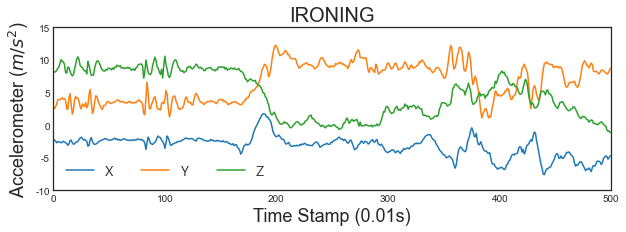

In [13]:
fig, ax = plt.subplots(figsize=(10, 3))
plt.rc('font', family='Malgun Gothic')

ax.plot(X[0])

ax.set_title(LABEL_TO_MOTION_MAP[Y[0]].upper(), fontsize=20)
ax.set_xlim(0, 500)
ax.set_ylim(-10, 15)
ax.set_xlabel('Time Stamp (0.01s)',      fontsize=18)
ax.set_ylabel('Accelerometer ($m/s^2$)', fontsize=18)
ax.legend('XYZ', ncol=3, loc='lower left', fontsize=14)

plt.show()

## 3. KNNClassifier Example
- 이 예제는 예시일 뿐이고, 다른 방식으로 구현하셔도 됩니다.

### 3.1. Process
#### 3.1.1. `extract_features_from_a_single_sample` 구현
- (500, 3) 크기의 데이터 샘플 하나를 입력받아 특성들을 1D numpy array로 반환합니다.
- 주어진 예제에서는 `mean`, `std` 특성들을 뽑아내고 있습니다.
- 아래는 시계열 데이터에 대한 대표적인 특성들입니다.
  - Time Domain 특성
    - min, max, amplitude, sum, absolute sum, euclidean norm, mean, absolute mean, mean absolute deviation, variance, standard deviation, zero crossings, auto-correlations, skewness, kurtosis, percentiles, power, root mean square, cross-correlation of axes, ...
  - Frequency Domain 특성
    - energy, entropy, power, spectral centroid, mean, median, standard deviation, dominant frequency, ...

#### 3.1.2. 전처리기 (Preprocessor) 추가
- 3.1.1.에서 뽑아낸 특성들을 전처리합니다.
- 주어진 예제에는 `PCA`가 포함되어 있습니다.
- [이 링크](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing)에서 Scikit Learn 라이브러리가 제공하는 전처리기 목록을 확인하실 수 있습니다.
- Scikit Learn 외의 라이브러리를 이용하셔도 됩니다.


#### 3.1.3. 분류기 튜닝
- 여러 변수들을 바꾸어가며 성능을 높입니다.
  - 어떤 특성을 사용할지
  - 어떤 전처리기를 사용할지
  - 전처리기/분류기의 하이퍼파라미터를 어떻게 정할지
- Cross Validation을 이용해서 테스트 결과를 예측하며 하이퍼파라미터를 설정할 수 있습니다.
  - `CrossValidation.ipynb`를 참고해주세요.

### 3.2. Example Code

In [110]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures

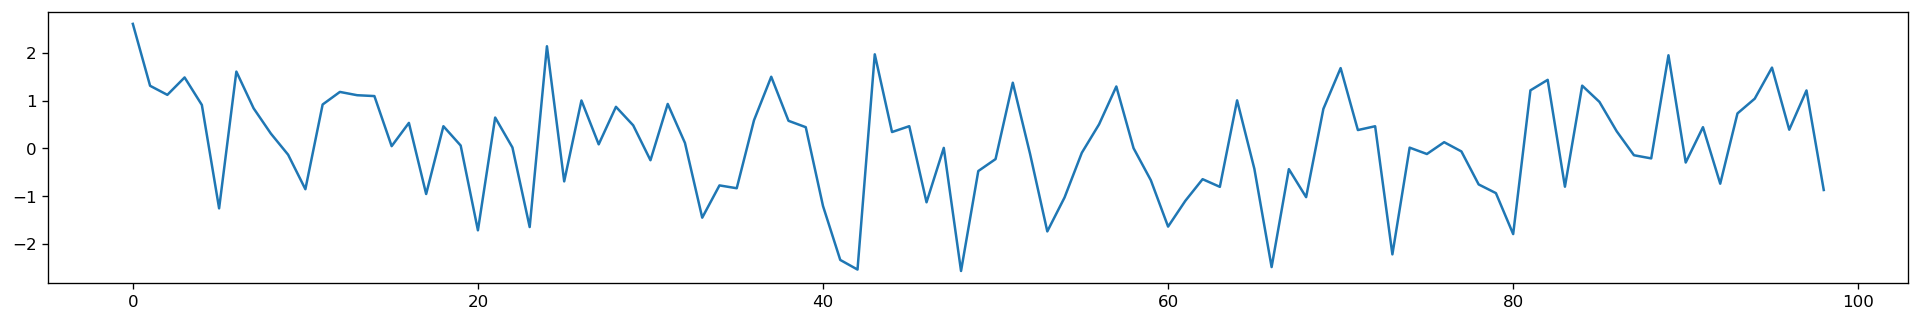

0.16133006015343762

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(0)
s = pd.Series(np.sin(range(1,100))) + pd.Series(np.random.randn(99)) # 임의의 time series 생성

plt.figure(facecolor='w',figsize=(20,3),dpi=120)
plt.plot(s)
plt.show()

s.autocorr(lag=1) # lag 1에 해당하는 autocorrelation을 리턴

In [188]:
def extract_features_from_a_single_sample(X_sample: np.ndarray) -> np.ndarray:
    """
    Extract features from a single sample

    Parameters
    ----------
    X_sample : array of shape (500, 3)
        100Hz * 5 seconds => 500
        3 axis (x, y, z)  => 3

    Returns
    -------
    features : array with (p,) shape
        Extracted features from X_sample
    """
    # - Time Domain 특성
    # - min, max, amplitude, sum, absolute sum, euclidean norm, mean, absolute mean, mean absolute deviation, variance, 
    # standard deviation, zero crossings, auto-correlations, skewness, kurtosis, percentiles, power, root mean square, 
    # cross-correlation of axes, ...
    # - Frequency Domain 특성
    # - energy, entropy, power, spectral centroid, mean, median, standard deviation, dominant frequency, ...
    
    #max = np.max(X_sample, axis=0)
    #min = np.min(X_sample, axis=0)
    
    X_fft = np.abs(np.fft.fft(X_sample, axis=0))[1:]  # Can be used for frequency domain features
    mean_fft = np.mean(X_fft, axis=0)
    std_fft = np.std(X_fft, axis=0)
    
    X_delta = abs(np.delete(X_sample,-1,axis=0) - np.delete(X_sample,0,axis=0))
    mean_delta = np.mean(X_delta, axis=0)
    std_delta = np.std(X_delta, axis=0)
    
    mean = np.mean(X_sample, axis=0)
    abs_sum = np.square(X_sample).sum()
    #mean_abs = np.mean(abs(X_sample), axis=0)
    std = np.std(X_sample, axis=0)
    cov_xy = np.cov(X_sample[:,0], X_sample[:,1])[0, 1]
    cov_yz = np.cov(X_sample[:,1], X_sample[:,2])[0, 1]
    cov_zx = np.cov(X_sample[:,2], X_sample[:,0])[0, 1]
    corr_xy = np.corrcoef(X_sample[:,0], X_sample[:,1])[0, 1]
    corr_yz = np.corrcoef(X_sample[:,1], X_sample[:,2])[0, 1]
    corr_zx = np.corrcoef(X_sample[:,2], X_sample[:,0])[0, 1]
    
    #features = np.hstack([mean, mean_fft, std_fft, abs_sum, std, cov_xy, cov_yz, cov_zx, corr_xy, corr_yz, corr_zx])
    features = np.hstack([mean, std, mean_fft, std_fft, mean_delta, std_delta, abs_sum])
    return features

def extract_features_from_multiple_samples(X_samples: np.ndarray) -> np.ndarray:
    """
    Extract features from multiple samples

    Parameters
    ----------
    X_samples : array of shape (n, 500, 3)
        List of data samples

    Returns
    -------
    array of shape (n, p)
        Extracted features from X_samples
    """
    return np.asarray([extract_features_from_a_single_sample(X_sample) for X_sample in X_samples])

LRClassifier = Pipeline([
    ('feature_extractor', FunctionTransformer(extract_features_from_multiple_samples)),
    ('preprocessor', PCA()),
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures()),
    #('classifier', RandomForestClassifier(n_estimators=100)),
    ('classifier', skl_lm.LogisticRegression()),
])

In [189]:
# Sample evaluation with test_subject
# Cross validation can be used to estimate more accurate test results.

#test_subject = np.max(subjects)
test_subject = 3
x_train = X[subjects != test_subject]
x_test  = X[subjects == test_subject]
y_train = Y[subjects != test_subject]
y_test  = Y[subjects == test_subject]

LRClassifier.fit(x_train, y_train)
#y_pred = LRClassifier.predict(x_test)
y_prob = LRClassifier.predict_proba(x_test)
y_pred = np.argmax(y_prob, axis=1)

print(classification_report(y_test, y_pred, labels=LABELS, target_names=MOTIONS))

                   precision    recall  f1-score   support

   Nordic walking       0.00      0.00      0.00         0
 ascending stairs       0.31      0.15      0.20        95
          cycling       0.00      0.00      0.00         0
descending stairs       0.93      0.74      0.82       139
          ironing       0.78      0.90      0.83       275
            lying       0.79      0.72      0.76       216
     rope jumping       0.00      0.00      0.00         0
          running       0.00      0.00      0.00         0
          sitting       0.92      0.82      0.87       283
         standing       0.72      0.77      0.74       201
  vacuum cleaning       0.97      0.94      0.96       199
          walking       0.78      0.93      0.85       286

         accuracy                           0.80      1694
        macro avg       0.52      0.50      0.50      1694
     weighted avg       0.81      0.80      0.80      1694



## 4. Problem
### 4.1. Problem
* 아래 빈 셀에 [KNNClassifier](#3.-KNNClassifier-Example)처럼 Motion을 유추할 수 있는 5가지 Classifier들을 구현합니다.
* 5가지 Classifier를 각각 아래와 같은 변수명으로 구현해야 하고, 주어진 방식으로 분류를 수행해야 합니다.
  * `LRClassifier` : Logistic Regression
  * `LDAClassifier` : Linear Discriminant Analysis
  * `RFClassifier` : Random Forest
  * `BClassifier` : Boosting with Decision Tree
  * `SVMClassifier` : Support Vector Machines

### 4.2. 채점기준
* 5가지 Classifier 각각 20점씩 배정됩니다.
* 20점 = 구현 (15점) + 성능 (5점)
  * 구현의 경우 성능과 관계 없이 fit, predict를 통해 Motion 예측이 이루어지면 점수를 모두 받으실 수 있습니다.
    * [Appendix: Test Code](#Appendix:-Test-Code)를 참고 부탁드립니다.
  * 성능의 경우 아래 코드와 같이 각 팀의 macro f1-score를 표준화 (standardization) 하여 0 ~ 5점 범위에 대응시킵니다.
    ```python
    import numpy as np
    from scipy import stats

    example_f1_scores = [0.9, 0.8, 0.5, 0.6, 0.65]
    zscores = stats.zscore(example_f1_scores)
    scores = 5 * (zscores - np.min(zscores)) / (np.max(zscores) - np.min(zscores))
    print(example_f1_scores)
    print(scores)
    # macro f1-score 0 ~ 1: [0.9, 0.8,  0.5, 0.6,  0.65 ]
    # scores         0 ~ 5: [5.0, 3.75, 0.0, 1.25, 1.875]
    ```

In [ ]:
############################################################
# Implement your own classifiers in this cell










LRClassifier  = None
LDAClassifier = None
RFClassifier  = None
BClassifier   = None
SVMClassifier = None
############################################################

## Appendix: Test Code
* 채점시 사용될 코드입니다.
* test 데이터가 없기 때문에 실행이 불가능하고, 참고만 부탁드립니다.

In [ ]:
import pickle
from sklearn.metrics import f1_score


# Load data
with open('data/train.pkl', 'rb') as f:
    df_train = pickle.load(f)
with open('data/test.pkl', 'rb') as f:
    df_test = pickle.load(f)

# Data arangement
X_train = np.stack(df_train['Data'])
X_test  = np.stack(df_test['Data'])
y_train = df_train['Motion'].map(MOTION_TO_LABEL_MAP).values
y_test  = df_test['Motion'].map(MOTION_TO_LABEL_MAP).values

# Test
for clf in [LRClassifier, LDAClassifier, RFClassifier, BClassifier, SVMClassifier]:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = f1_score(y_test, y_pred, average='macro')
    print(score)